# Exam Data based Modeling and Control

## Setup

### Imports and Configuration for notebook

Setting up the notebook for data processing and importing all tools needed for analysis

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from models import utils
from models import arx, hammerstein, dmd, dmdc, errors

In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

### Loading the data into the notebook

In [7]:
data1 = utils.read_mat('/home/matthias/WS_all/dbm/raw/exam/ex1_data.mat')
data2 = utils.read_mat('/home/matthias/WS_all/dbm/raw/exam/ex2_data.mat')

display(data1.keys())

data1.y = data1.y.flatten()
data1.u = data1.u.flatten()
data1.t = data1.t.flatten()
display(data2.keys())

dict_keys(['__header__', '__version__', '__globals__', 'para', 't', 'u', 'y'])

dict_keys(['__header__', '__version__', '__globals__', 'X', 't', 'u'])

## Task 1



Consider the provided dataset `ex1_data.mat` to be processed either using MATLAB or Python. Solve the following tasks. Prepare your code so that one can easily adjust the input for evaluation purposes.

1. **Recursive Least-Squares Approach**  
    Use a recursive least-squares approach to identify the transfer function that relates the output y_k  to the input u_k:

    $$
    y_k = G(q)u_k
    $$

    *Choose an appropriate model structure for G(q) to suit the problem.*

---

2. **Nonlinear Problem with Hammerstein Model**  
    The problem under consideration is known to be nonlinear, but the nonlinearity is unknown. Extend your approach using a Hammerstein model and use a polynomial to describe the nonlinearity in terms of the input u_k.


---

### Visual inspektion of the data

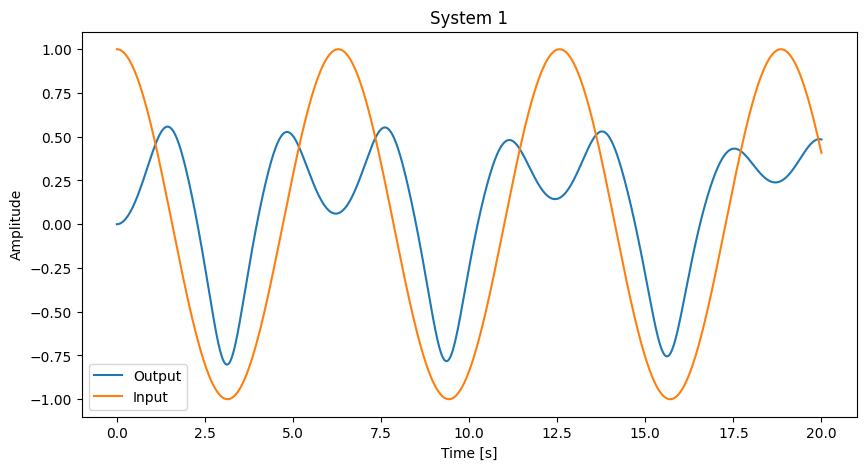

In [78]:
plt.figure(figsize=(10, 5))
plt.plot(data1.t,data1.y)
plt.plot(data1.t,data1.u)
plt.title('System 1')
plt.xlabel('Time [s]')

plt.ylabel('Amplitude')
plt.legend(['Output', 'Input'])

plt.show()


### 1.1 Identify the System Using RLS



To address the system identification task, I developed an optimizer that accepts input and output data, along with a specified range for `na` and `nb` (model orders for the ARX structure).

The ARX model structure is defined as:

$$
y_k = -\sum_{i=1}^{na} a_i y_{k-i} + \sum_{j=1}^{nb} b_j u_{k-j}
$$

where:

- `na` — number of past outputs to include
- `nb` — number of past inputs to include

then the corresponding discrete-time transfer function is:

$$
G(q^{-1}) = \frac{B(q^{-1})}{A(q^{-1})} = \frac{b_1 q^{-1} + b_2 q^{-2} + \dots + b_{n_b} q^{-n_b}}{1 + a_1 q^{-1} + a_2 q^{-2} + \dots + a_{n_a} q^{-n_a}}
$$

#### Optimizer Workflow

1. **Parameter Grid:**  
   Construct a grid from the given `na` and `nb`.

2. **Model Fitting:**  
   Iterate over the parameter grid and fit the ARX model using the Recursive Least Squares (RLS) algorithm.

3. **Simulation:**  
   Simulate the model response using the fitted parameters.

4. **Error Computation:**  
   Compare the simulated response to the actual output and compute an error metric.

5. **Parameter Update:**  
   If the computed error is smaller than the current best, update the best set of parameters.

After evaluating all parameter combinations, the optimizer returns the best-performing set of parameters.


In [79]:
p, loss, na,nb = arx.optimize(data1.y,data1.u,(1,20),(1,20))


Testing 361 combinations.
Progress: 0.28 %
Current iteration: 1 / 361
Iteration took 0.38 seconds, average 0.19 seconds
Progress: 27.98 %
Current iteration: 101 / 361
Iteration took 0.20 seconds, average 0.22 seconds
Progress: 55.68 %
Current iteration: 201 / 361
Iteration took 0.36 seconds, average 0.34 seconds
Progress: 83.38 %
Current iteration: 301 / 361
Iteration took 0.38 seconds, average 0.36 seconds


In [3]:
display(f"Model parameters: {p}")
display(f"Mean absolute error: {loss}")
display(f"ARX model order: NA: {na}, NB:{nb}")
utils.print_tf(p)

NameError: name 'p' is not defined

#### Simulate the output of the model

The model output is simulated by advancing one time step per iteration using the parameter vector

In [81]:
y_out = arx.simulate(jnp.array([0]), data1.u,na, nb, p.flatten())

#### Visual inspektion of the difference

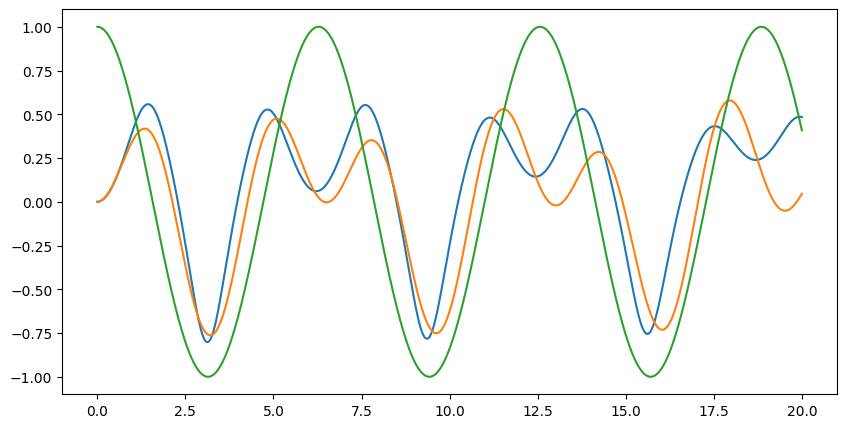

In [82]:
plt.figure(figsize=(10, 5))
plt.plot(data1.t, data1.y, label='data')
plt.plot(data1.t, y_out, label='model')
plt.plot(data1.t, data1.u, label='input')
plt.show()

### 1.2 Hammerstein Model



#### Optimizer


To address the system identification task, I developed an optimizer that accepts input and output data, along with a specified range for:

- `na`, `nb`: ARX model orders
- `p`: Polynomial order
- `e`: Binary mask indicating active polynomial terms
- `c`: Polynomial coefficients

---

#### Hammerstein Polynomial

The static nonlinearity in the Hammerstein model is defined by a masked polynomial:

$$
y = \sum_{i=0}^{n} c_i \cdot x^{p - i} \cdot e_i
$$

where:

- `e_i` ∈ {0, 1} — indicates whether the `i`-th term is active  
  _(e.g., for a first-order term only: `e = [1, 0, 0, ...]`)_
- `p` — highest order of the polynomial
- `c_i` — coefficient of the `i`-th polynomial term
---

#### Optimizer Workflow

1. **Parameter Grid:**  
   Construct a grid of combinations from the provided `na`, `nb`, `p`, `e`, and `c`.

2. **Model Fitting:**  
   For each parameter combination, fit the Hammerstein model using the Recursive Least Squares (RLS) algorithm.

3. **Simulation:**  
   Simulate the system response using the fitted model parameters.

4. **Error Computation:**  
   Compare the simulated response to the actual output and compute an error metric.

5. **Parameter Update:**  
   If the error improves over the current best, update the stored best parameters.

---

After evaluating all parameter combinations, the optimizer returns the best-performing set of parameters.

In [83]:
hp = hammerstein.optimize(data1.y,data1.u,(3,5), (1,2), (4,5), (2,4), (0.1,0.9))

Total parameters: 800
Progress: 0.12 %. Current iteration time: 0.22s, average: 0.11 seconds, CPU: 13.00%, RAM: 58.20%
Progress: 12.62 %. Current iteration time: 0.25s, average: 0.25 seconds, CPU: 35.90%, RAM: 58.10%
Progress: 25.12 %. Current iteration time: 0.20s, average: 0.20 seconds, CPU: 32.30%, RAM: 58.00%
Progress: 37.62 %. Current iteration time: 0.19s, average: 0.20 seconds, CPU: 36.90%, RAM: 59.10%
Progress: 50.12 %. Current iteration time: 0.31s, average: 0.28 seconds, CPU: 37.80%, RAM: 59.20%
Progress: 62.62 %. Current iteration time: 0.24s, average: 0.25 seconds, CPU: 39.10%, RAM: 59.50%
Progress: 75.12 %. Current iteration time: 0.19s, average: 0.19 seconds, CPU: 37.40%, RAM: 58.80%
Progress: 87.62 %. Current iteration time: 0.20s, average: 0.20 seconds, CPU: 36.80%, RAM: 58.90%


#### Inspect Parameter

In [85]:
params = hp.param_vector
loss = hp.loss
func = hp.func
order = hp.order
na = hp.na
nb = hp.nb

display(params)

print("Transfer function:")
utils.print_tf(params, na, nb)
display(f"Mean absolute error: {loss}")
display(f"Hammerstein model order: NA: {na}, NB: {nb}, Order: {order}")

Array([ 1.672153  , -0.4015309 , -0.2860076 ,  0.44629422, -0.4883157 ,
       -0.48963228,  0.5446671 ,  0.13370736, -0.15738189, -0.12308934,
        0.13614324,  0.06653827, -0.07657156], dtype=float32)

Transfer function:


NameError: name 'max_' is not defined

#### Simulate Hammerstein model

In [64]:
yh_out = hammerstein.simulate(jnp.array([0]), data1.u,na,nb, order, func, params)

#### Visual inspection

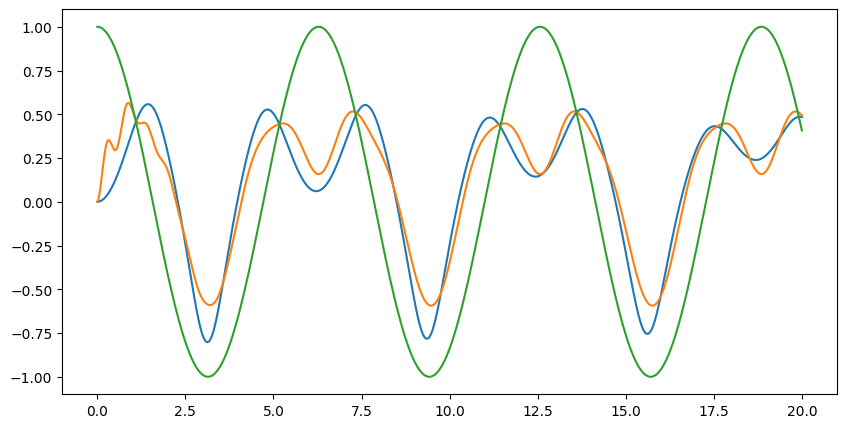

In [65]:
plt.figure(figsize=(10, 5))
plt.plot(data1.t, data1.y, label='data')
plt.plot(data1.t, yh_out, label='model')
plt.plot(data1.t, data1.u, label='input')
plt.show()

## Task 2:



Consider the provided data set `ex2_data.mat` to be processed either using MATLAB or Python. Note that the samples at time t_k are given by the column vectors of the data matrix \( X \) in the mat-file.

Solve the following tasks. Prepare your code so that one can easily adjust the input for evaluation purposes.

---

### 2.1 Model Representation in Reduced Order Form

Determine a model representation of the provided data in the reduced order form

$$
\tilde{x}(t_k) = C\, z(t_k) + B\, u(t_k),
$$

$$
z(t_{k+1}) = A\, z(t_k), \quad t_k \geq 0,
$$

$$
z(t_0) = z_0,
$$

where the model order (i.e., the dimension of z(t_k) does not exceed a user-defined value.)

---

### 2.2 Measure for Choosing the Model Order r

Provide one measure on how to choose a suitable value of r. For example, one could use:


---


#### Extracting the data

In [8]:

x = data2.X[:,:-1]
x_prime = data2.X[:,1:]
u = data2.u[:, :-1]
x0 = x[:,0]

z = jnp.linspace(0,1,x.shape[0])
t = data2.t.flatten()



#### Visual inspection of data

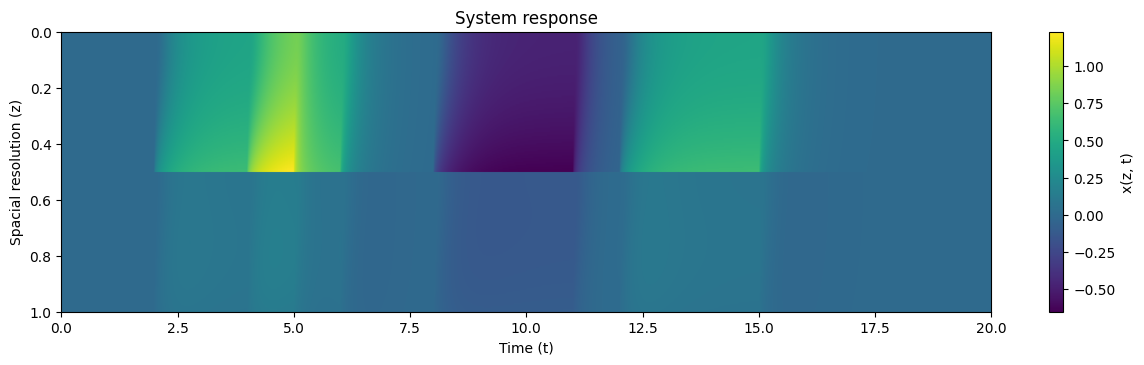

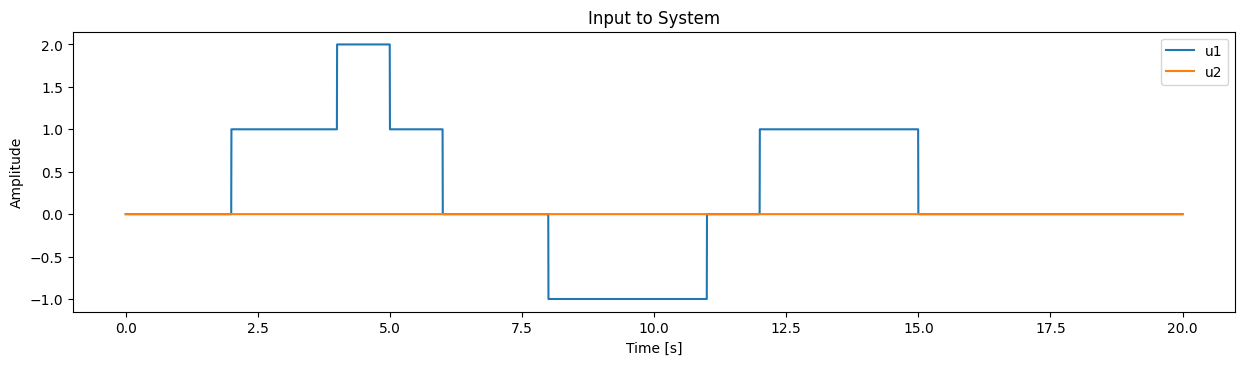

In [9]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.imshow(x, extent=[t[0], t[-1], z[-1], z[0]], aspect='auto', cmap='viridis')
plt.colorbar(label='x(z, t)')
plt.xlabel('Time (t)')
plt.ylabel('Spacial resolution (z)')
plt.title('System response')
plt.show()

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(t, data2.u[:1, :].flatten())
plt.plot(t, data2.u[1:, :].flatten())
plt.title('Input to System')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(['u1', 'u2'])
plt.show()

#### Fit DMDc



To fit the DMDc model, I developed an optimizer that automatically selects the optimal model rank based on reconstruction error.

- `x`, `x_prime`: State snapshots at times t_k, t_{k+1}  
- `u`: Control input snapshots  
- `r_range`: Range of model ranks to evaluate  
- `cutoff`: Optional energy threshold for early stopping

---

#### Optimizer Workflow

1. **Model Fitting:**  
   For each rank \( r \), fit a reduced-order DMDc model using truncated SVD.

2. **Simulation:**  
   Simulate the system response using the learned model.

3. **Error Evaluation:**  
   Compute the mean absolute reconstruction error between true and simulated states.

4. **Model Selection:**  
   Track and retain the model with the lowest reconstruction error.

5. **Energy Cutoff (Optional):**  
   Stop early if the retained energy drops below the given threshold.

---

The optimizer returns the best rank along with the corresponding reduced-order model.

In [ ]:
r,a,b, lam, transform = dmdc.optimize(x, x_prime, u, (1,20))
display(f"Model rank: {r}")


'Model rank: 7'

#### Simulate DMDc





To simulate the DMDc model, I implemented a function that propagates the system state over time using the reduced-order dynamics.

Given:

- `x0`: Initial state in full space
- `u`: Control input sequence.
- `a`, `b`: Reduced-order system and input matrices.
- `transform`: Transformation matrix to project between full and reduced state spaces

---

The simulation proceeds by:

1. **Projection:**  
   Project the initial full state into reduced space:
   $$
   z_0 = \text{transform}^\top x_0
   $$

2. **Reduced-State Propagation:**  
   Simulate in reduced space:
   $$
   z_{k+1} = A_{\text{tilde}} z_k + B_{\text{tilde}} u_k
   $$

3. **Reconstruction:**  
   Transform reduced states back into full space:
   $$
   x_k = \text{transform} \cdot z_k
   $$

In [69]:
r = dmdc.simulate(x0,u.T,a,b,transform).real.T

r1 = dmdc.simulate(x0[:101],u.T,a,b,transform[:101]).real.T

r2 = dmdc.simulate(x0[101:],u.T,a,b,transform[101:]).real.T

#### Visually inspect the difference

Array(0.00343307, dtype=float32)

Array(0.00829338, dtype=float32)

Array(0.00586331, dtype=float32)

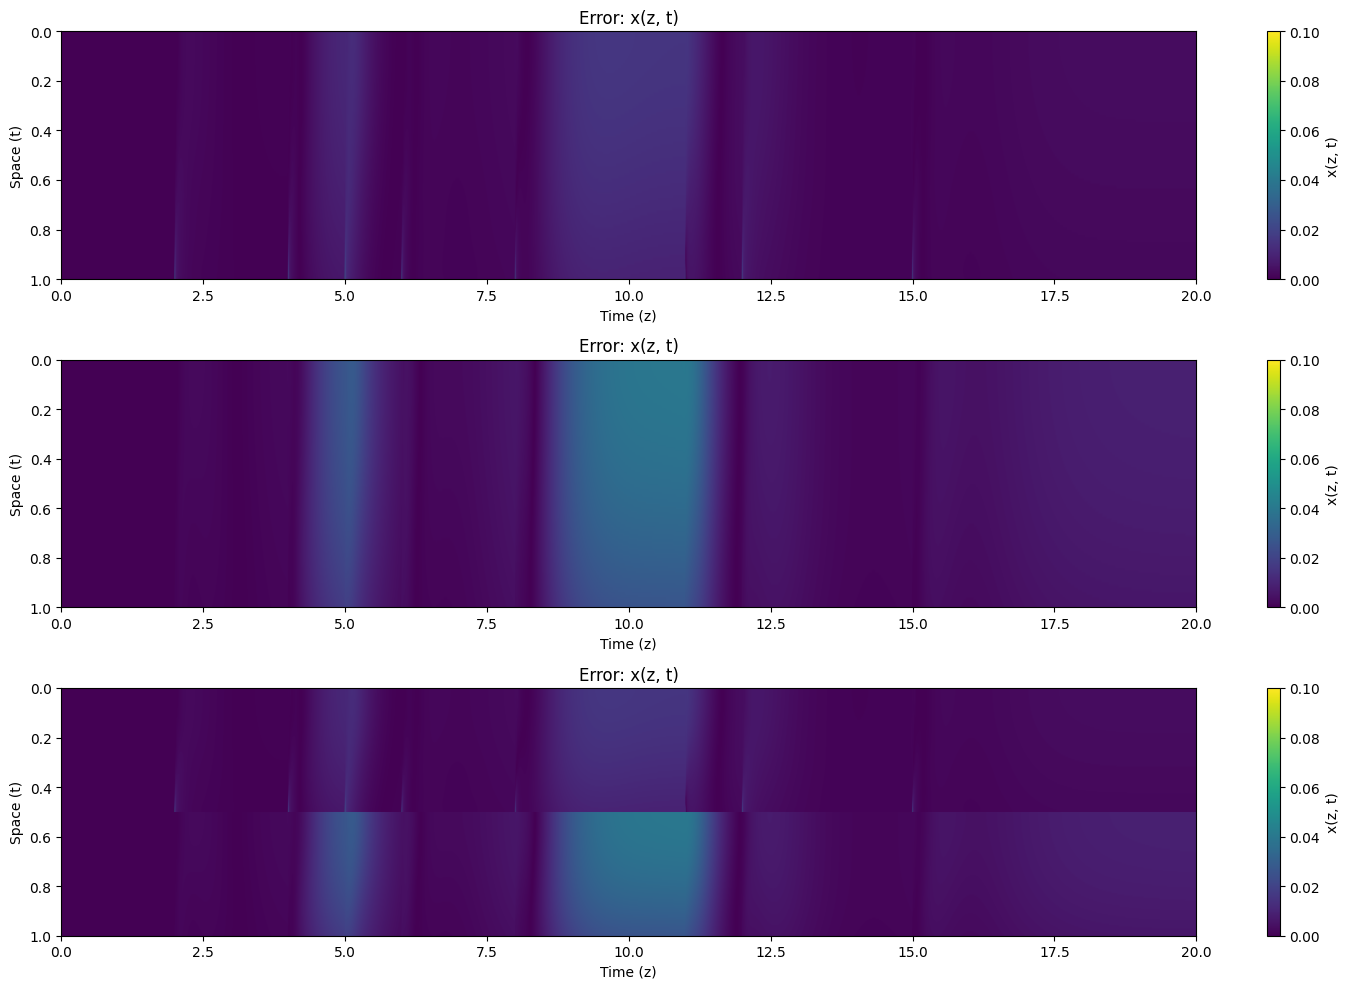

In [ ]:



diff2 = errors.absolute_error(data2.X[101:,:], r2)
display(jnp.mean(diff2))
plt.subplot(3, 1, 2)
plt.imshow(diff2, vmin = 0, vmax =0.1, extent=[t[0], t[-1], z[-1], z[0]], aspect='auto', cmap='viridis')
plt.colorbar(label='x(z, t)')
plt.xlabel('Time (z)')
plt.ylabel('Space (t)')
plt.title('Error: x(z, t)')
plt.tight_layout()

diff3 = errors.absolute_error(x, r[:,:-1])
display(jnp.mean(diff3))
plt.subplot(3, 1, 3)
plt.imshow(diff3, vmin = 0, vmax =0.1, extent=[t[0], t[-1], z[-1], z[0]], aspect='auto', cmap='viridis')
plt.colorbar(label='x(z, t)')
plt.xlabel('Time (z)')
plt.ylabel('Space (t)')
plt.title('Error: x(z, t)')
plt.tight_layout()
plt.show()



Array(0.00343307, dtype=float32)

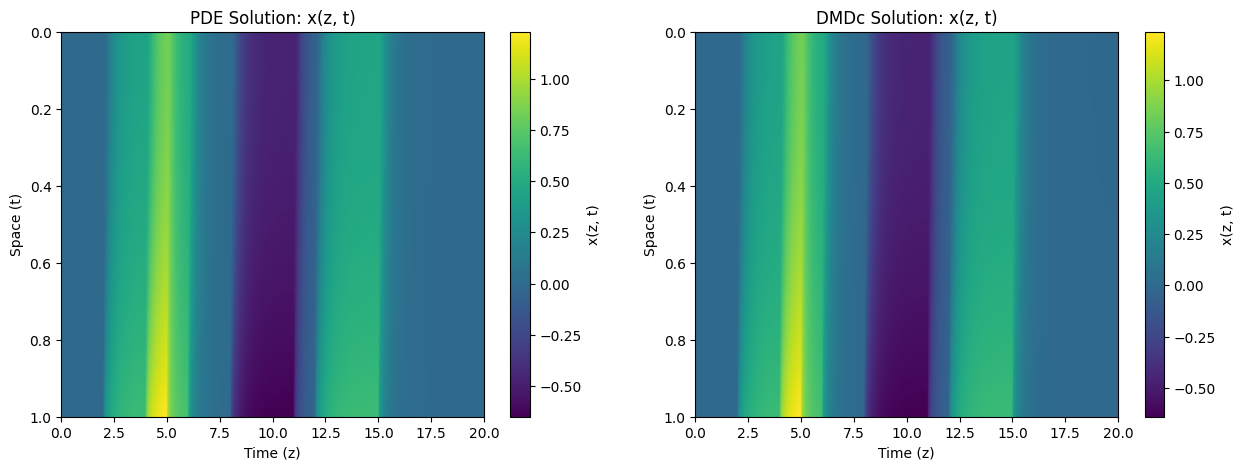

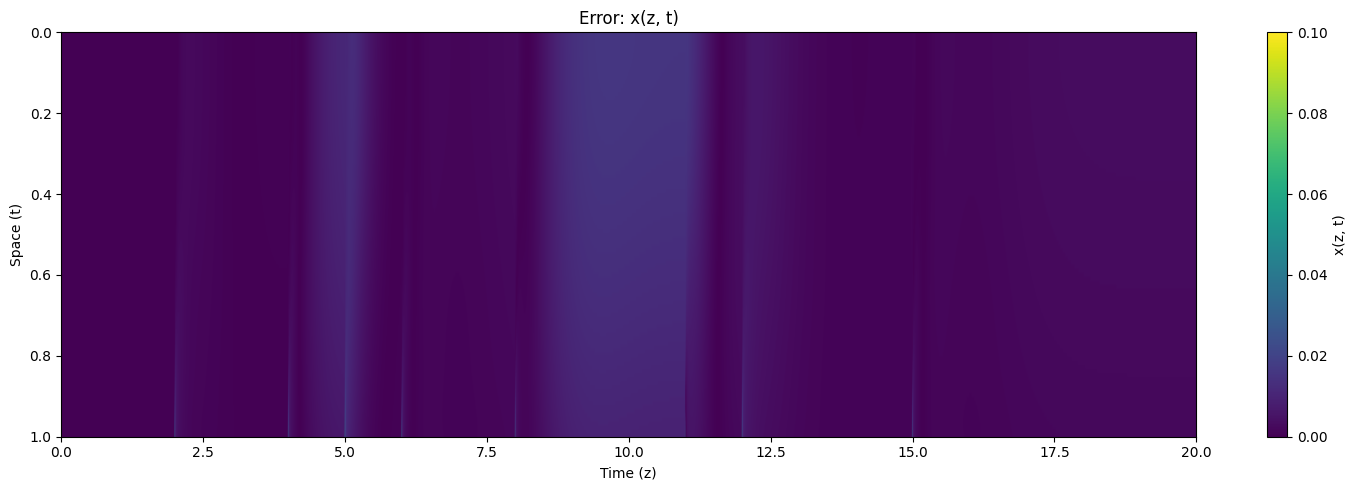

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(x[:101, :], extent=[t[0], t[-1], z[-1], z[0]], aspect='auto', cmap='viridis')
plt.colorbar(label='x(z, t)')
plt.xlabel('Time (z)')
plt.ylabel('Space (t)')
plt.title('PDE Solution: x(z, t)')

plt.subplot(1, 2, 2)
plt.imshow(r1, extent=[t[0], t[-1], z[-1], z[0]], aspect='auto', cmap='viridis')
plt.colorbar(label='x(z, t)')
plt.xlabel('Time (z)')
plt.ylabel('Space (t)')
plt.title('DMDc Solution: x(z, t)')


# Diff
diff = errors.absolute_error(data2.X[:101,:], r1)
display(jnp.mean(diff))
plt.figure(figsize=(15, 5))

plt.subplot(1, 1, 1)
plt.imshow(diff,vmin= 0, vmax = 0.1, extent=[t[0], t[-1], z[-1], z[0]], aspect='auto', cmap='viridis')
plt.colorbar(label='x(z, t)')
plt.xlabel('Time (z)')
plt.ylabel('Space (t)')
plt.title('Error: x(z, t)')

plt.tight_layout()
plt.show()

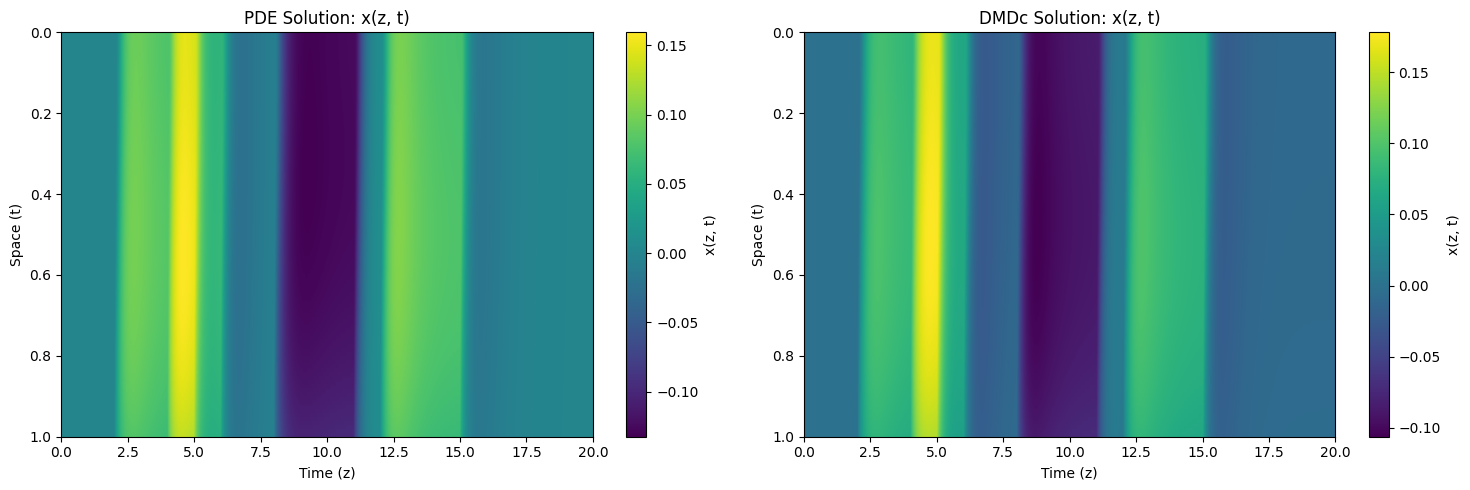

In [73]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(x[101:, :], extent=[t[0], t[-1], z[-1], z[0]], aspect='auto', cmap='viridis')
plt.colorbar(label='x(z, t)')
plt.xlabel('Time (z)')
plt.ylabel('Space (t)')
plt.title('PDE Solution: x(z, t)')

plt.subplot(1, 2, 2)
plt.imshow(r2, extent=[t[0], t[-1], z[-1], z[0]], aspect='auto', cmap='viridis')
plt.colorbar(label='x(z, t)')
plt.xlabel('Time (z)')
plt.ylabel('Space (t)')
plt.title('DMDc Solution: x(z, t)')

plt.tight_layout()
plt.show()